## import

In [1]:
import numpy as np
import os, random
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Lambda
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

C:\Users\HW-steve\miniconda3\envs\points\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HW-steve\miniconda3\envs\points\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HW-steve\miniconda3\envs\points\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HW-steve\miniconda3\envs\points\lib\site-packages

## random seed

In [2]:
ramdom_seed = 5198
tf.random.set_random_seed(ramdom_seed)
np.random.seed(ramdom_seed)
random.seed(ramdom_seed)
os.environ['PYTHONHASHSEED'] = str(ramdom_seed)

## GPU growth

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

## Preprocessing function

In [4]:
def mat_mul(A, B):
    return tf.matmul(A, B)

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

def rotate_point_cloud(batch_data):
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data

def jitter_point_cloud(batch_data, sigma=0.001, clip=0.005):
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data

In [133]:
def model_create():
    # number of points in each sample
    num_points = 10000

    # number of categories
    k = 3

    # define optimizer
    adam = optimizers.Adam(lr=0.001, decay=0.7)

    # ------------------------------------ Pointnet Architecture
    # input_Transformation_net
    input_points = Input(shape=(num_points, 3))
    x = Convolution1D(64, 1, activation='relu', input_shape=(num_points, 3))(input_points)
    x = Convolution1D(128, 1, activation='relu')(x)
    x = Convolution1D(1024, 1, activation='relu')(x)
    x = MaxPooling1D(pool_size=num_points)(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
    input_T = Reshape((3, 3))(x)

    # forward net
    g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
    g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
    g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)

    # feature transform net
    f = Convolution1D(64, 1, activation='relu')(g)
    f = Convolution1D(128, 1, activation='relu')(f)
    f = Convolution1D(1024, 1, activation='relu')(f)
    f = MaxPooling1D(pool_size=num_points)(f)
    f = Dense(512, activation='relu')(f)
    f = Dense(256, activation='relu')(f)
    f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
    feature_T = Reshape((64, 64))(f)

    # forward net
    g = Lambda(mat_mul, arguments={'B': feature_T})(g)
    g = Convolution1D(64, 1, activation='relu')(g)
    g = Convolution1D(128, 1, activation='relu')(g)
    g = Convolution1D(1024, 1, activation='relu')(g)

    # global_feature
    global_feature = MaxPooling1D(pool_size=num_points)(g)

    # point_net_cls
    c = Dense(512, activation='relu')(global_feature)
#     c = Dropout(rate=0.2)(c)
    c = Dense(256, activation='relu')(c)
#     c = Dropout(rate=0.2)(c)
    c = Dense(k, activation='sigmoid')(c)
    prediction = Flatten()(c)
    # --------------------------------------------------end of pointnet

    # print the model summary
    model = Model(inputs=input_points, outputs=prediction)
    model.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])
    
    return model

In [134]:
data_path = 'D:/DATA/data_2020-05-21_knu_deid/data_ply_np.npy'

In [135]:
train_np = np.load(data_path)
# train_jitter = jitter_point_cloud(train_np, sigma = 0.1, clip = 1)

label_path = 'D:/DATA/data_2020-05-21_knu_deid/angle_class_labels.csv'
df = pd.read_csv(label_path, delimiter=',')
angle_label = df['Angle Class Model'].tolist() 
angle_label_np = np.array(angle_label)
angle_label_np = angle_label_np - 1

In [136]:
print('data shape :', train_np.shape, 'labels shape :', angle_label_np.shape)

data shape : (129, 10000, 3) labels shape : (129,)


In [137]:
# def data_generator(train_np, anger_label_np, batch_size, aug = True):
#     idx = 0
#     idx_list = list(range(train_np.shape[0])) # random shuffle index generation
#     anger_label_cate = to_categorical(anger_label_np -1)
    
#     while 1:        
#         if idx > len(idx_list) - batch_size:
#             tmp_list = idx_list[idx:]
#             idx = 0
#         else:
#             tmp_list = idx_list[idx:idx+batch_size] # end of list batch 
#             idx = idx + batch_size
            
#         batch_points = train_np[tmp_list, ...]
#         batch_labels = anger_label_cate[tmp_list, ...]

#         if aug == True:
#             train_points_jitter = jitter_point_cloud(batch_points, sigma = 0.1, clip = 1)
#         else:
#             train_points_jitter = batch_points
                
#         yield train_points_jitter, batch_labels

In [138]:
kfold = StratifiedKFold(n_splits=10, random_state=ramdom_seed) 

C:\Users\HW-steve\miniconda3\envs\points\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [139]:
# history_all = []
# eval_all = []
# for train_index, test_index in kfold.split(train_np, angle_label_np): 
#     model = model_create()
#     train_input = train_np[train_index]
#     train_label = to_categorical(angle_label_np[train_index])
#     test_input = train_np[test_index]
#     test_label = to_categorical(angle_label_np[test_index])
#     history = model.fit(train_input, train_label, batch_size = 64, epochs = 100)
#     history_all.append(history)
#     eval_ = model.evaluate(test_input, test_label, batch_size = 64)
#     eval_all.append(eval_)

In [140]:
history_all = []
eval_all = []
for train_index, test_index in kfold.split(train_np, angle_label_np): 
    model = model_create()
    train_input = train_np[train_index]
    train_label = to_categorical(angle_label_np[train_index])
    test_input = train_np[test_index]
    test_label = to_categorical(angle_label_np[test_index])
    history = model.fit(train_input, train_label, batch_size = 64, epochs = 50, validation_data = [test_input, test_label], validation_steps =2)
    history_all.append(history)
    eval_ = model.evaluate(test_input, test_label, batch_size = 64)
    eval_all.append(eval_)

Train on 116 samples, validate on 13 samples
Epoch 1/50
116/116 [==============================] - 7s 59ms/sample - loss: 0.3261 - acc: 0.3793 - val_loss: 0.2747 - val_acc: 0.3846
Epoch 2/50
116/116 [==============================] - 1s 11ms/sample - loss: 0.2716 - acc: 0.3276 - val_loss: 0.3032 - val_acc: 0.3077
Epoch 3/50
116/116 [==============================] - 1s 11ms/sample - loss: 0.2760 - acc: 0.3621 - val_loss: 0.2688 - val_acc: 0.3077
Epoch 4/50
116/116 [==============================] - 1s 11ms/sample - loss: 0.2652 - acc: 0.3621 - val_loss: 0.2478 - val_acc: 0.3846
Epoch 5/50
116/116 [==============================] - 1s 11ms/sample - loss: 0.2534 - acc: 0.3276 - val_loss: 0.2329 - val_acc: 0.3846
Epoch 6/50
116/116 [==============================] - 1s 11ms/sample - loss: 0.2329 - acc: 0.3276 - val_loss: 0.2236 - val_acc: 0.4615
Epoch 7/50
116/116 [==============================] - 1s 11ms/sample - loss: 0.2259 - acc: 0.3879 - val_loss: 0.2337 - val_acc: 0.3077
Epoch 8/50

In [145]:
a =[[0.1593429446220398, 0.6923077],
 [0.29449814558029175, 0.30769232],
 [0.21242481470108032, 0.61538464],
 [0.22741523385047913, 0.53846157],
 [0.1677170842885971, 0.53846157],
 [0.16508954763412476, 0.6923077],
 [0.1893545687198639, 0.53846157],
 [0.19857051968574524, 0.46153846],
 [0.1869758814573288, 0.53846157],
 [0.14321906864643097, 0.5833333]]


In [146]:
a = np.array(a)

In [147]:
np.mean(a, axis = 0)

array([0.19446078, 0.55064104])

In [141]:
eval_all

[[0.1593429446220398, 0.6923077],
 [0.29449814558029175, 0.30769232],
 [0.21242481470108032, 0.61538464],
 [0.22741523385047913, 0.53846157],
 [0.1677170842885971, 0.53846157],
 [0.16508954763412476, 0.6923077],
 [0.1893545687198639, 0.53846157],
 [0.19857051968574524, 0.46153846],
 [0.1869758814573288, 0.53846157],
 [0.14321906864643097, 0.5833333]]

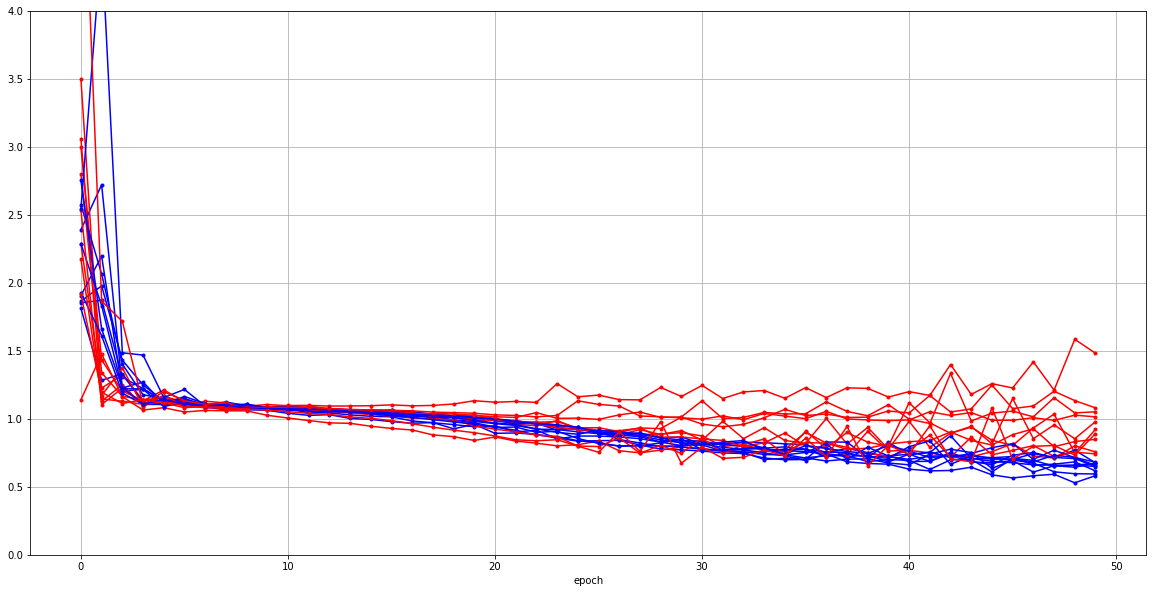

In [117]:
x_len = np.arange(len(history_all[0].history['loss']))

plt.figure(figsize = (20, 10))
for i in range(len(history_all)):
    plt.plot(x_len, history_all[i].history['loss'], marker='.', c='blue', label="Train-set Loss")
    plt.plot(x_len, history_all[i].history['val_loss'], marker='.', c='red', label="Val-set Loss")
# plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylim((0, 4))
plt.show()

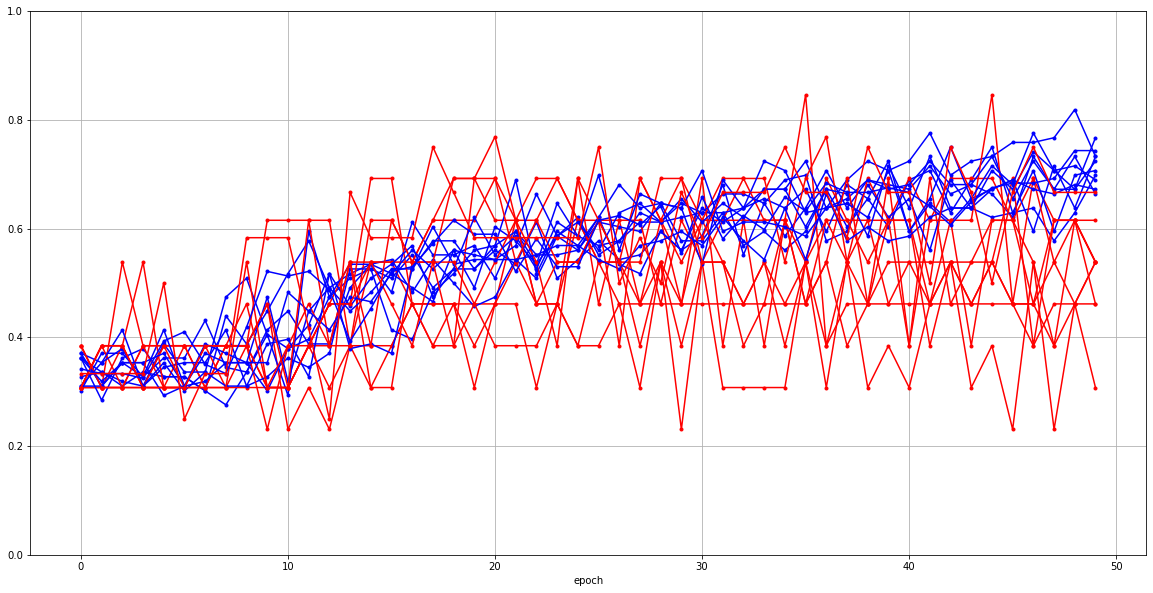

In [118]:
x_len = np.arange(len(history_all[0].history['loss']))

plt.figure(figsize = (20, 10))
for i in range(len(history_all)):
    plt.plot(x_len, history_all[i].history['acc'], marker='.', c='blue', label="Train-set acc")
    plt.plot(x_len, history_all[i].history['val_acc'], marker='.', c='red', label="Val-set acc")
# plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.show()

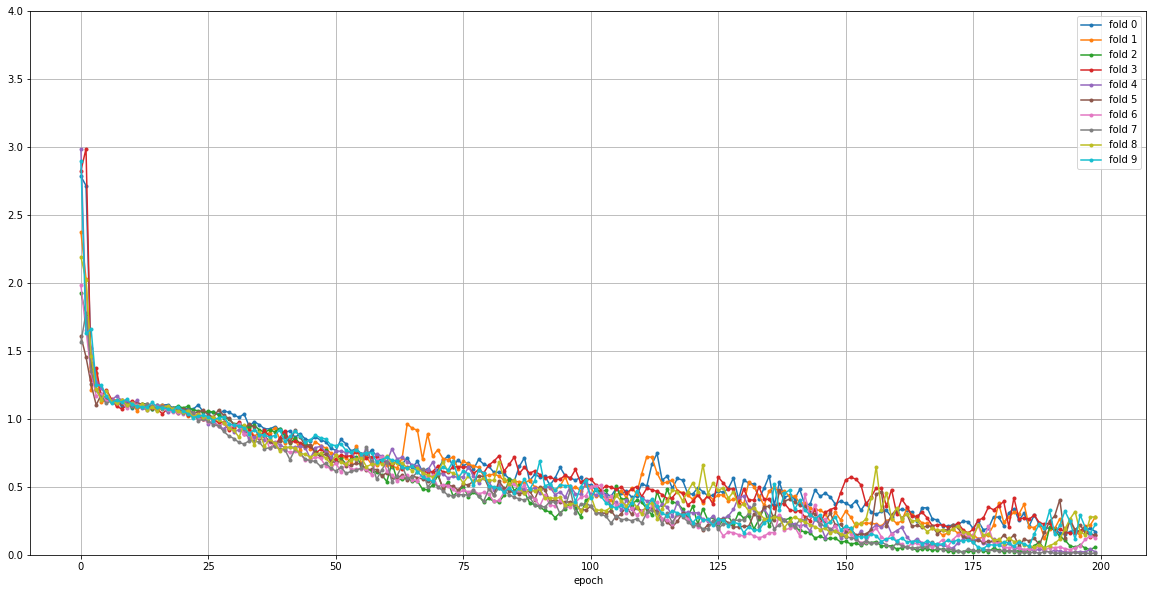

In [99]:
# y_loss = history_all.history['loss']
# y_acc = history_all.history['acc']

x_len = np.arange(len(history_all[0].history['loss']))

plt.figure(figsize = (20, 10))
for i in range(len(history_all)):
    plt.plot(x_len, history_all[i].history['loss'], marker='.', label= f"fold {i}")
    # plt.plot(x_len, history_all[i].history['acc'], marker='.', c='red', label="Train-set Accuracy")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylim((0, 4))
plt.show()

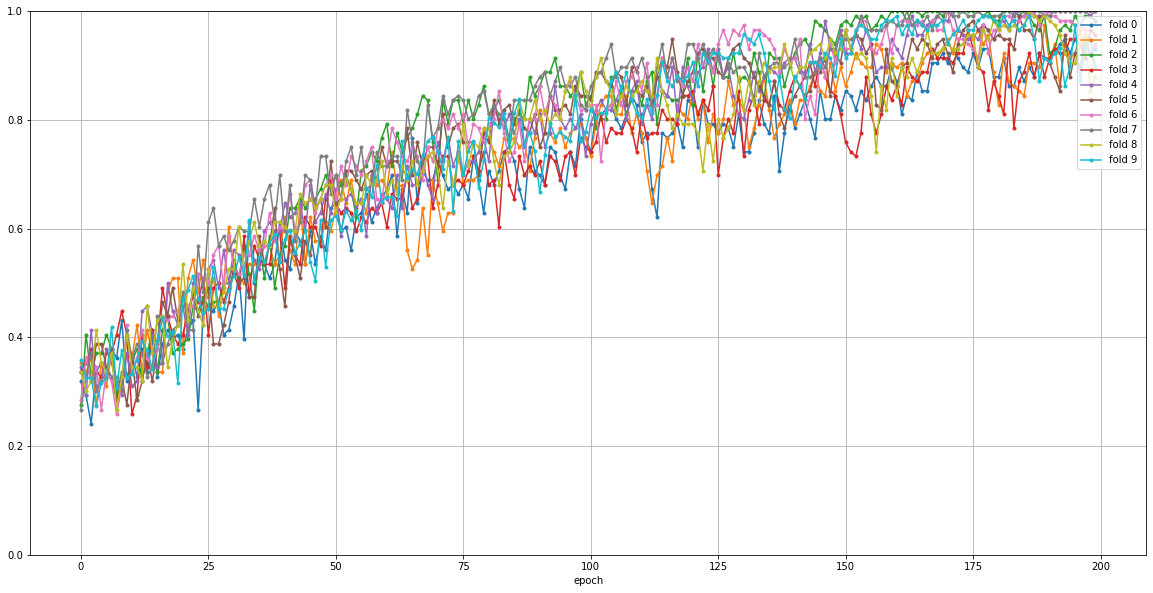

In [100]:
# y_loss = history_all.history['loss']
# y_acc = history_all.history['acc']

x_len = np.arange(len(history_all[0].history['loss']))

plt.figure(figsize = (20, 10))
for i in range(len(history_all)):
#     plt.plot(x_len, history_all[i].history['loss'], marker='.', c='blue', label= f"fold {i}")
    plt.plot(x_len, history_all[i].history['acc'], marker='.', label=f"fold {i}")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.show()